In [7]:
from pylab import *
from casadi import *
import time
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


In [8]:
normalization = 1e9
δ  = 0.02
α  = 0.045007414
κ  = 2.094215255
pf = 20.76
ζ  = 1.66e-4 * normalization 
p2 =  44.75
ξ = 20

In [9]:
#Site Data
df = pd.read_csv("data/calibration_25SitesModel.csv")
z̄ = (df['zbar_2017_25Sites'].to_numpy() )/normalization
n = len(z̄)

σγ_list = df['gammaSD_25Sites'].to_numpy() *np.ones((1,n))

σθ_list =  df['thetaSD_25Sites'].to_numpy()*np.ones((1,n))

σ_list = np.concatenate((σγ_list,σθ_list), axis = 1 )
cov_list = σ_list * np.identity(2*n) *σ_list

meanγ = df['gamma_25Sites'].to_numpy()
meanθ = df['theta_25Sites'].to_numpy()
mean= np.concatenate((meanγ, meanθ))

z0_list = df['z_2017_25Sites'].to_numpy()
γ_post_list = (meanγ*np.ones((1,n))).T
θ_post_list = (meanθ*np.ones((1,n))).T
post_list = np.concatenate((γ_post_list, θ_post_list))
Z0_list = z0_list/ normalization

γ_list_mean_posterior = γ_post_list
θ_list_mean_posterior = θ_post_list
mean_posterior = np.concatenate((γ_post_list, θ_post_list))

γ_post_list_old = γ_post_list
θ_post_list_old = θ_post_list
post_list_old = np.concatenate((γ_post_list_old, θ_post_list_old))


In [10]:

def normal(z, μ, Σ):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    μ: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """


    N = n

    temp2 = -.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ)

    return  temp2

In [11]:
simulation = 100000
vec  = np.zeros((2*n,simulation+1))
vec[:,0]= mean

In [12]:
error = 1e9
tol = 0.05

In [13]:
leng=200
arr = np.cumsum(
                   np.triu(
                     np.ones((leng, leng))
                   ), axis=1)

Bdym=(1-α)**(arr-1)
Bdym[Bdym>1] = 0 
Bdym = Bdym.T

Adym = (np.linspace(1,200,200)*np.ones((1,200))).T

# Explaining the Code


1. Optimization Phase: For a given $\tilde \gamma$ we solve the problem, using some sort of optimization algorithm (IPOPT in our case),  

\begin{equation}
      \left\{ \int_0^\infty \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\} 
\end{equation}

\begin{equation} \label{eq:z}
\dot Z_t^i = U_t^i - V_t^i . 
\end{equation}

\begin{equation} \label{eq:x}
{\dot X}_t^i  = - \tilde \gamma^i U^i_t - \alpha \left[ X_t^i - \tilde \gamma^i  \left( {{\bar z}^i - Z_t^i }  \right) \right] 
\end{equation}

$$
X_0^i = \tilde \gamma^i * C
$$

where $C$ is some constant. 

2. MC phase: The algorithm for this part is the standard Metropolis-Hastings Algorirthm. The only thing that is a bit troublesome to deal with is the formulation of our likelihood which is $g$. 

    1. We are given $\gamma^*$ via the MHMC algorithm. 
    2. Use $U_t^i$ and $V_t^i$ to evaluate the objective function under $\gamma^*$. 
    3. Form the Likelihood $g$

\begin{equation}\label{min_solution}
g^* = \exp\left[ - {\frac 1 \xi } \left\{ \int_0^\infty \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\} \right]
\end{equation} 
    
    


In [14]:
era = 0
while error > tol: 
    x0_list = post_list[0:n].T * df['forestArea_2017_ha_25Sites'].to_numpy()
    X0_list = x0_list/ normalization
    #Construct Matrix A
    Az = np.zeros((n, n+2))
    Ax = np.zeros((1, n+2))

    Ax[0:1,0:n-0] = -α *post_list[0:n].T
    Ax[0, -1] = np.sum(α*post_list[0:n].T * z̄)
    Ax[0,-2]  = -α

    A  = np.concatenate((Az, Ax, np.zeros((1, n+2))), axis=0)
    
    # Construct Matrix B
    Bz = np.identity((n))
    Bx = (np.zeros((1,n)))
    B  = np.concatenate((Bz, Bx,  np.zeros((1, n))), axis=0)
    
    # Construct Matrix B
    Dz =   np.zeros((n,n))
    Dx = -(np.ones((1,n))*post_list[0:n].T)

    D  = np.concatenate((Dz, Dx, np.zeros((1, n))), axis=0)
    
    T   = 200
    N   = T

    dt = T/N
    Y = MX.sym('Y'  ,n + 2) 
    up = MX.sym('up',n) 
    um = MX.sym('um',n) 

    rhs = (sparsify(A)@Y + sparsify(B)@(up-um) + sparsify(D)@(up))*dt + Y
    f = Function('f', [Y, um, up],[rhs])

    import math
    ds_vect = np.zeros((N+1,1))
    for i in range(N+1):
        ds_vect[i]=math.exp(-δ*i*dt)   
        
    opti = casadi.Opti()

    # Decision variables for states

    X = opti.variable(n+2 ,N+1)
    # Aliases for states

    Up = opti.variable(n,N)
    Um = opti.variable(n,N)
    Ua = opti.variable(1,N)
    
    # 1.2: Parameter for initial state
    ic = opti.parameter(n+2-0)

    # Gap-closing shooting constraints
    for k in range(N):
        opti.subject_to(X[:,k+1]==f(X[:,k],Um[:,k], Up[:,k]))

    # Initial and terminal constraints
    opti.subject_to(X[:,0] == ic)
    opti.subject_to(opti.bounded(0,X[0:n,:],z̄[0:n]))
    # Objective: regularization of controls
    # 1.1: added regularization
    for k in range(n-0):
        opti.subject_to(opti.bounded(0,Um[k,:],inf))
        opti.subject_to(opti.bounded(0,Up[k,:],inf))

    opti.subject_to(Ua == sum1(Up+Um)**2 )

    opti.minimize( sum2(ds_vect[0:N,:].T*(Ua* ζ/2 ))
                  - sum2(ds_vect[0:N,:].T*(pf*X[-2,1:] - pf*X[-2,0:-1]  ))
                  - sum2(ds_vect.T*sum1((p2*post_list[n:] - pf*κ )*X[0:n-0,:] )))

    # solve optimization problem 
    options = dict()
    options["print_time"] = False
    options["expand"]     = True
    options["ipopt"]      = {
                        'print_level': 0,
                        'fast_step_computation':            'yes',
                        'mu_allow_fast_monotone_decrease':  'yes',
                        'warm_start_init_point':            'yes',
                            }
    opti.solver('ipopt',options)

    t1 = time.time()
    opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
    sol = opti.solve()
    
    
    trace = {"γθ":np.zeros((simulation,n*2))}
    θ_list_comp = post_list[n:].T * np.ones((1,n))
    
    objective_value = -(sum2(ds_vect[0:T,:].T*(sol.value(Ua)* ζ/2 ))
                      - sum2(ds_vect[0:T,:].T*(pf*sol.value(X)[-2,1:] 
                                               - pf*sol.value(X)[-2,0:-1]  ))
                      - sum2(ds_vect.T*sum1((p2*θ_list_comp - pf*κ ).T*sol.value(X)[0:n,:] )))
    
    fγ̄ =   -.5 * (post_list - mean_posterior).T @ np.linalg.inv(cov_list) @ (post_list - mean_posterior)
    N_star_old = -1/ξ * objective_value  + fγ̄ 
    
    print('prepare simulations')
    st = time.time()
    innov = stats.multivariate_normal(np.zeros_like(mean), cov_list).rvs(size=simulation)
    u = stats.uniform(0, 1).rvs(simulation)
    
    for episode in range(simulation):
        list_prime = (post_list.flatten() + innov[episode,:])
        while np.sum(list_prime <0)>0 :
            innov_temp = stats.multivariate_normal(np.zeros_like(mean), cov_list).rvs(size=1)
            list_prime = (post_list.flatten() + innov_temp)
            
        x0_list = list_prime[0:n].T * df['forestArea_2017_ha_25Sites'].to_numpy()
        X0_list = x0_list/ normalization
        
        θ_list_comp = post_list[n:].T * np.ones((1,n))
        z̄_comp = z̄ * np.ones((1,n))
        
        X_dym_list = np.zeros((1,T+1))
        X_zero_list = np.sum(X0_list)*np.ones((200,1))
        X_dym_list[:,0] = np.sum(X0_list)
        ω =   (list_prime[0:n].T@(α*z̄_comp.T- α*sol.value(X)[0:n,:-1]) -list_prime[0:n].T@sol.value(Up))
        X_dym_list[:,1:] =( (((1-α)**Adym.flatten()))*X_zero_list.flatten()  +(Bdym@ω.T).flatten() )
        objective_value = -(sum2(ds_vect[0:T,:].T*(sol.value(Ua)* ζ/2 ))
                      - sum2(ds_vect[0:T,:].T*(pf*X_dym_list[:,1:] 
                                               - pf*X_dym_list[:,0:-1]  ))
                      - sum2(ds_vect.T*((p2*list_prime[n:]  - pf*κ )@sol.value(X)[0:n,:] )))
        
        
        fγ̄ =   -.5 * (list_prime - mean_posterior).T @ np.linalg.inv(cov_list) @ (list_prime - mean_posterior)
        N_star = -1/ξ * objective_value    + fγ̄
    
        RC_pre = np.array(N_star-N_star_old)
        RC = np.nanmin(np.array([0, RC_pre[0,0]]))
        if np.log(u[episode]) < RC : 
            N_star_old = N_star
            post_list = list_prime
            
            
        if episode % 10000 == 0:
            et = time.time()
            print(f'Simulation {episode}')
            elapsed_time = et - st
            print('Execution time:', elapsed_time, 'seconds')
            st = time.time()

        trace["γθ"][episode:episode+1] = list_prime.T
    post_list = (np.sum(trace["γθ"], axis=0 )/simulation *np.ones((1,n*2))).T/4 + post_list_old*3/4
    error =np.max(abs(post_list_old-post_list)/post_list_old)
    print(error)
    post_list_old = post_list
    vec[:, era+1:era+2] = post_list
    Posterior = trace["γθ"]
    plt.plot(vec[0:n,:era+2].T)
    plt.title('γ tilting')
    plt.show()
    plt.plot(vec[n:,:era+2].T)
    plt.title('θ titling')
    plt.show()
    era = era+1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

prepare simulations
Simulation 0
Execution time: 0.2621920108795166 seconds


In [ ]:
mc = simulation*10

In [ ]:
    list_mc = stats.multivariate_normal(mean, cov_list).rvs(size=mc)
    list_mc = list_mc[(list_mc >= 0).all(axis=1)]
    while np.shape(list_mc)[0] < mc:
        list_mc_temp = stats.multivariate_normal(mean, cov_list).rvs(size = mc - np.shape(list_mc)[0])
        if np.size(list_mc_temp)> n*2:
            list_mc_temp = list_mc_temp[(list_mc_temp >= 0).all(axis=1)]
        else:
            list_mc_temp = (list_mc_temp*np.ones((1,n*2)))
        list_mc = np.concatenate((list_mc, list_mc_temp), axis=0)

In [ ]:
np.save(f'pe_{pf}_xi_{ξ}_25sites', Posterior)

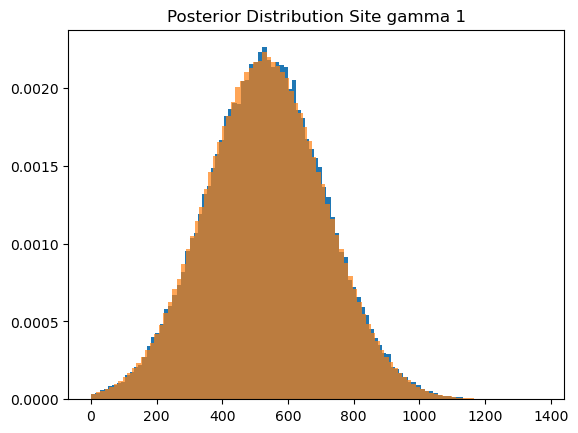

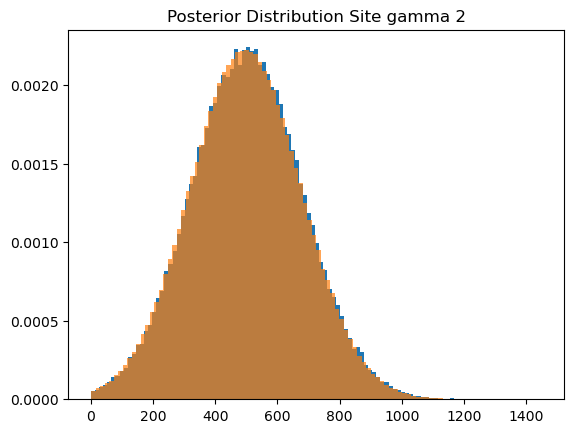

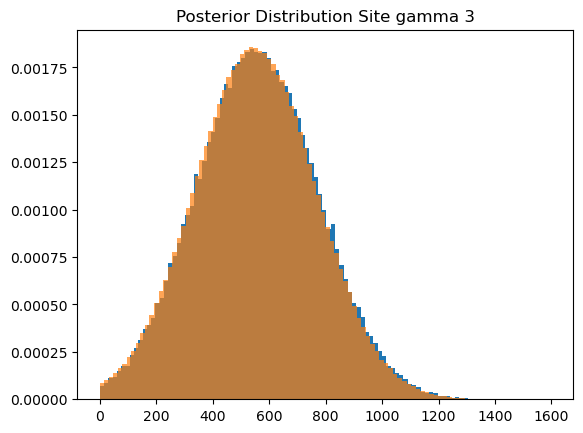

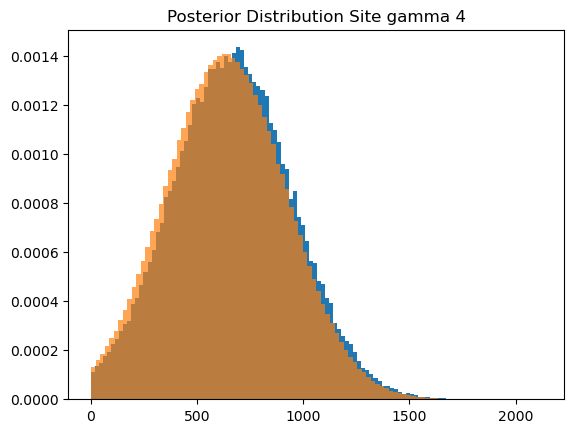

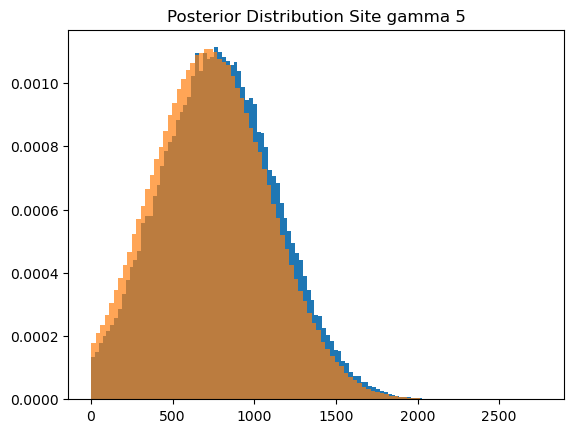

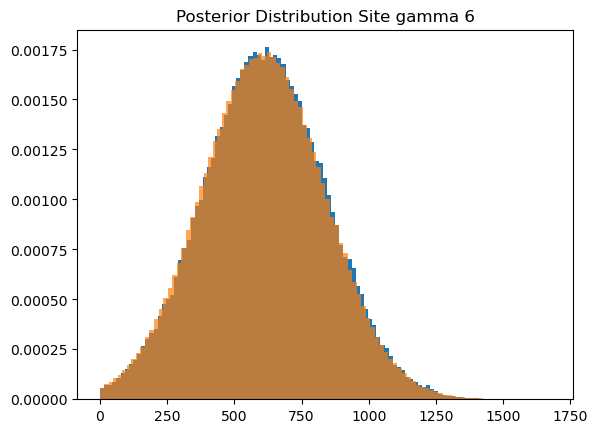

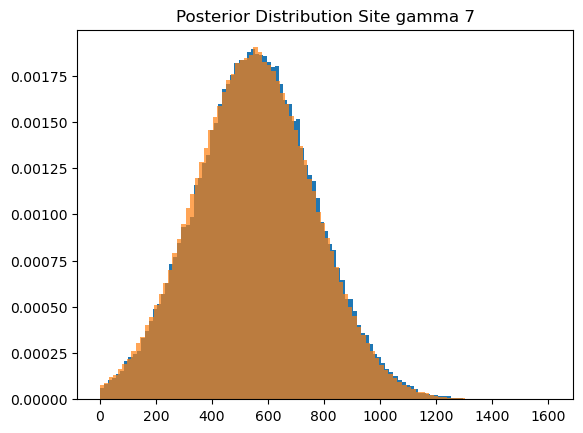

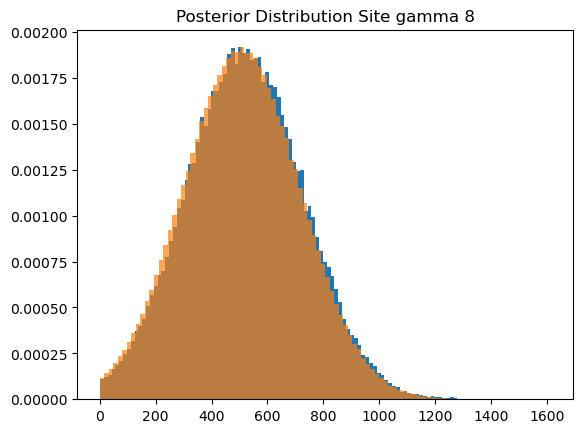

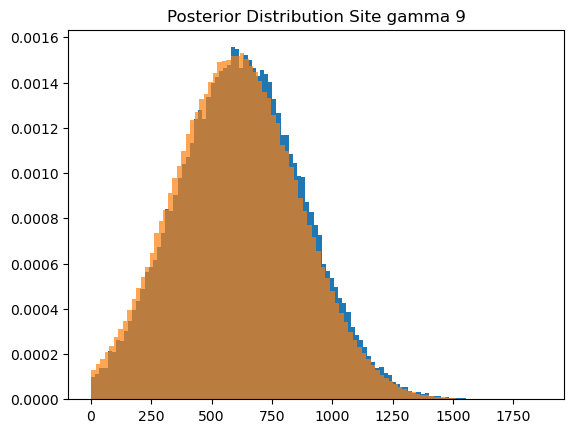

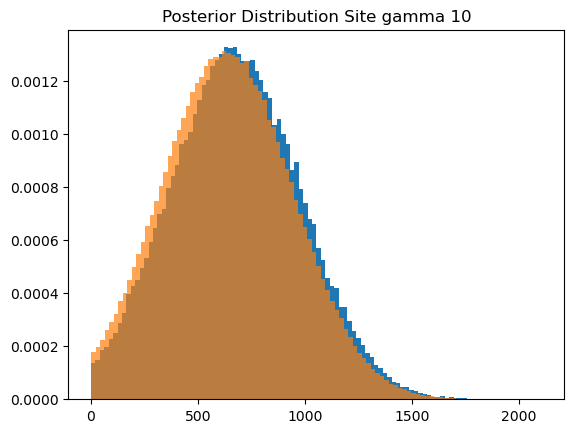

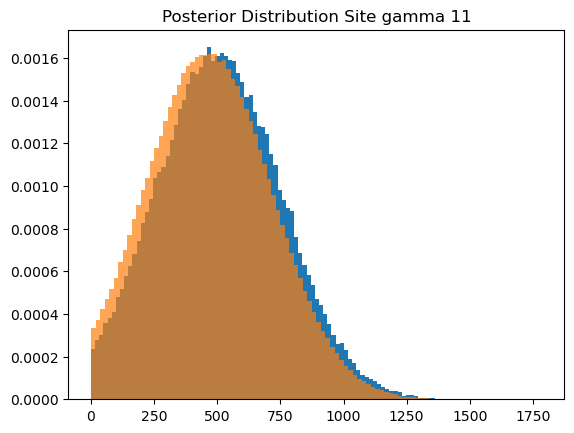

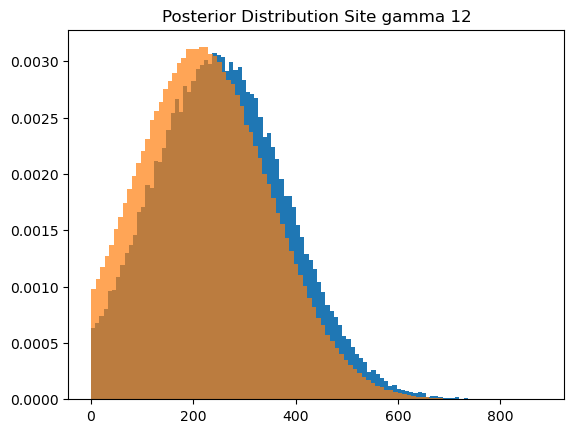

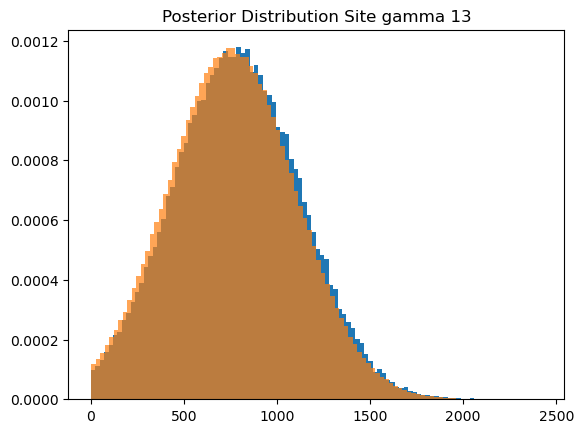

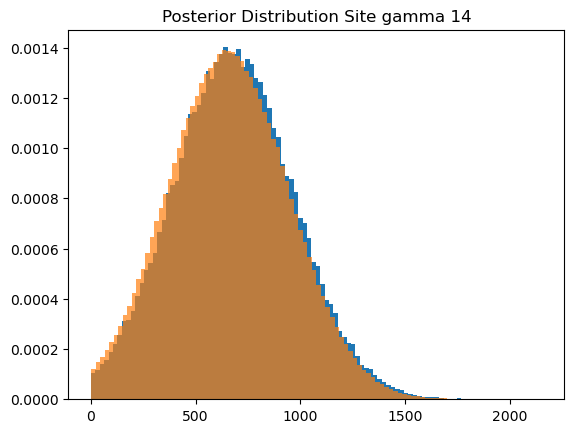

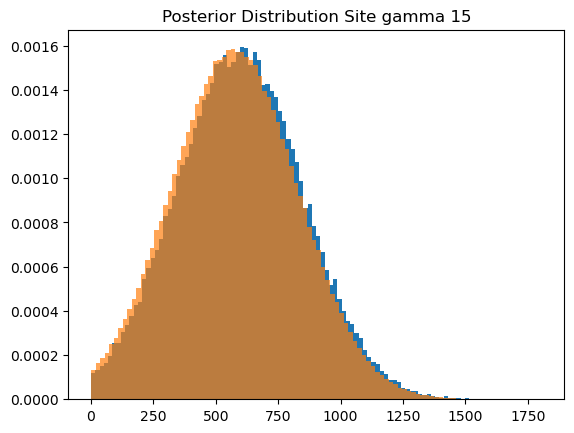

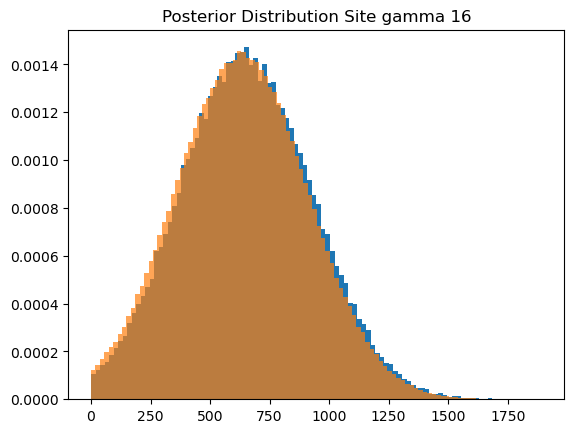

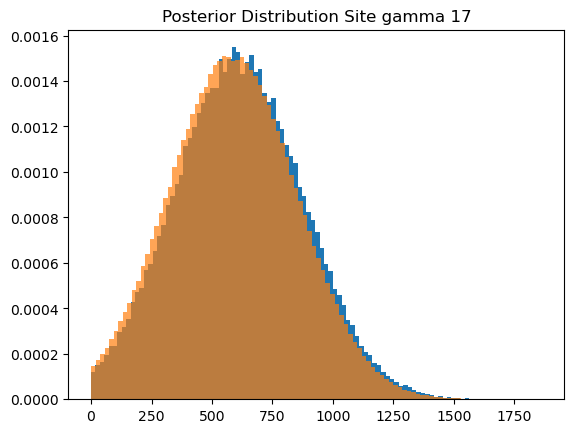

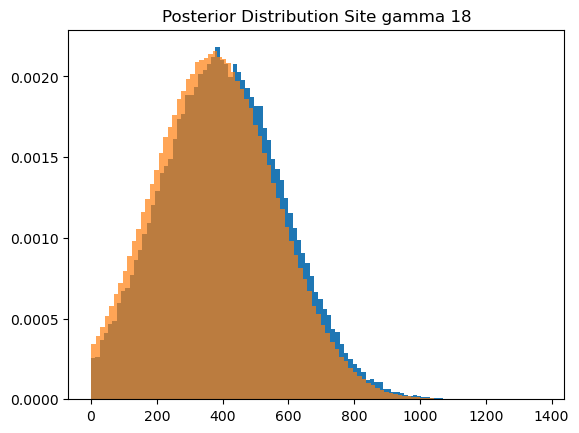

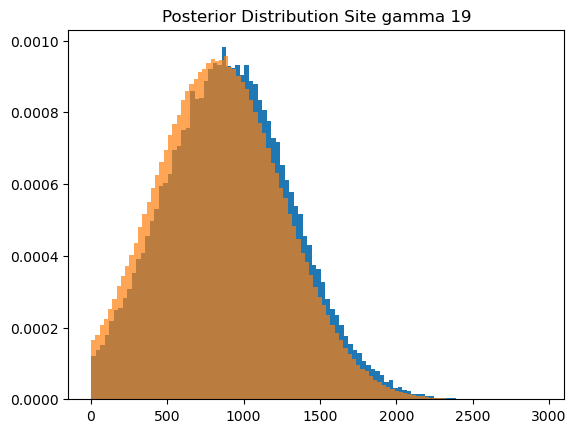

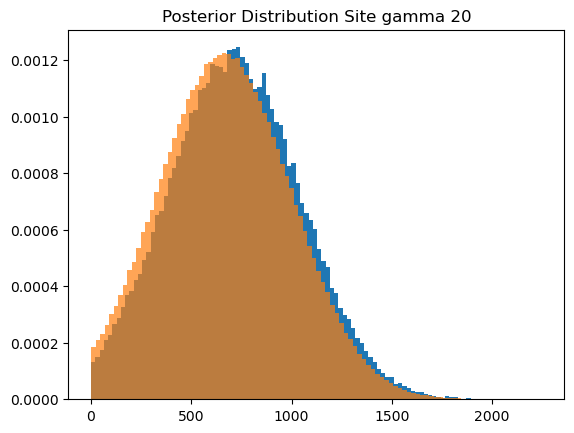

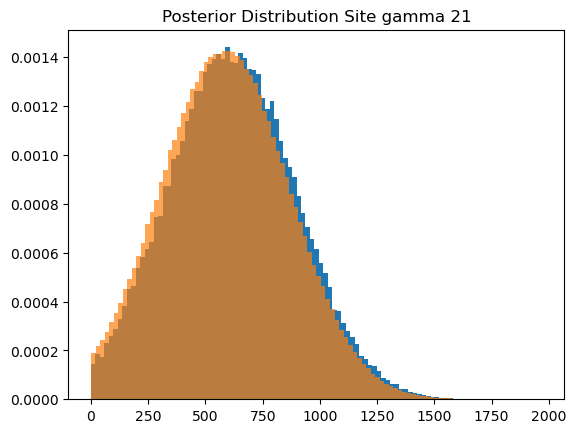

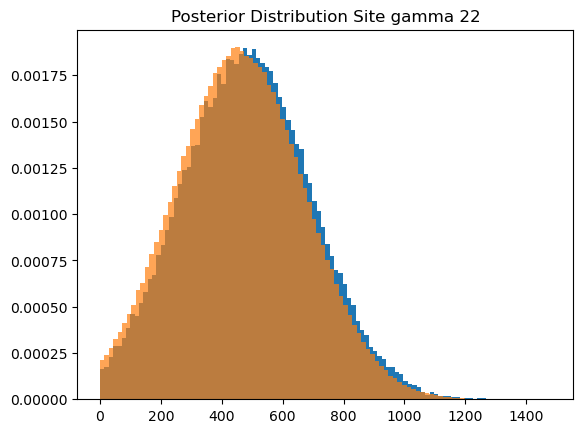

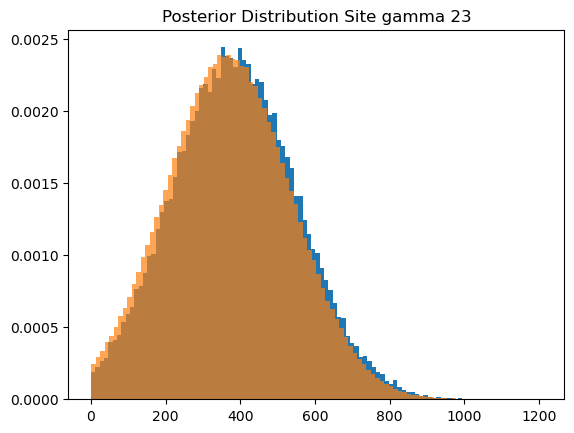

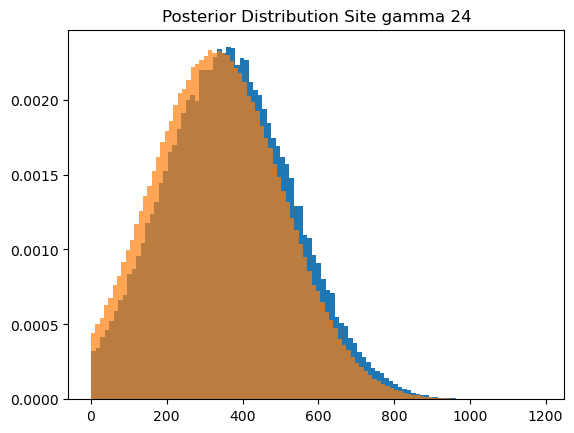

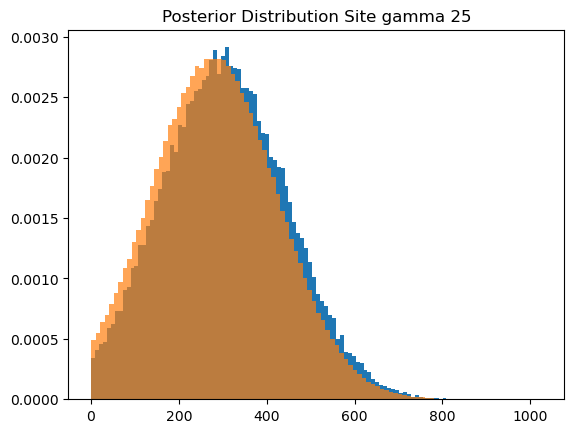

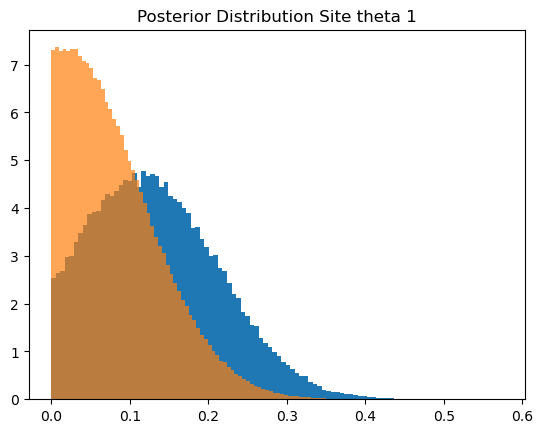

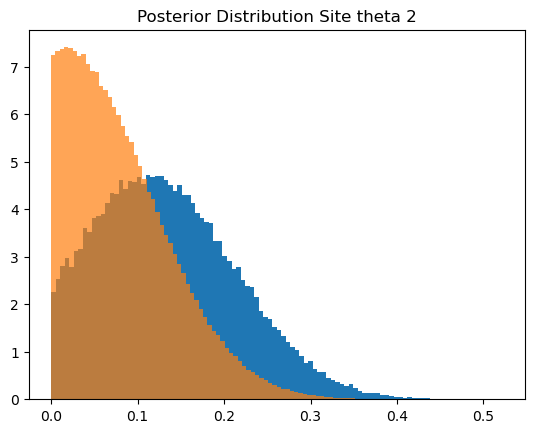

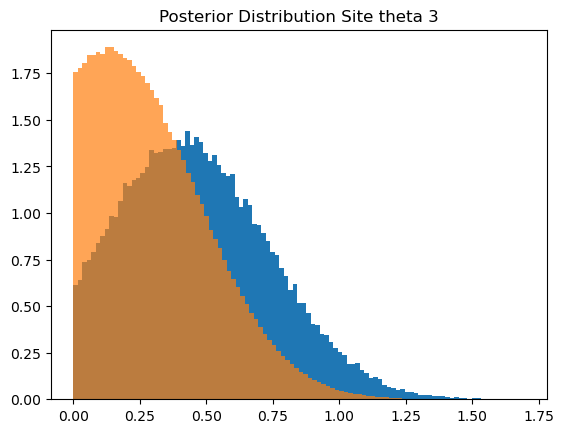

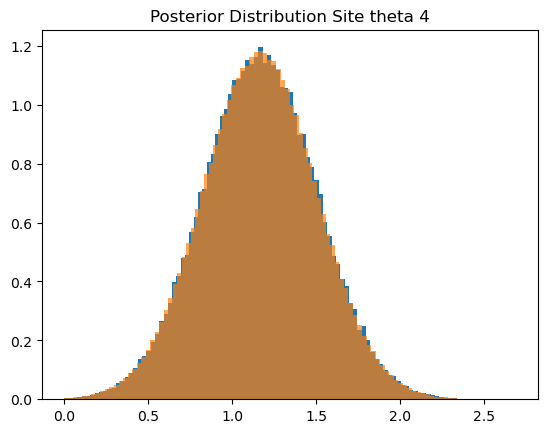

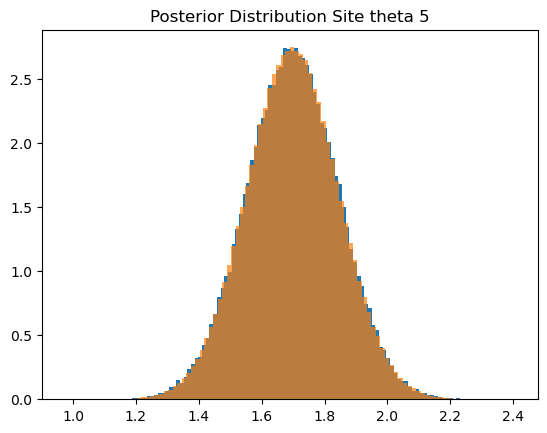

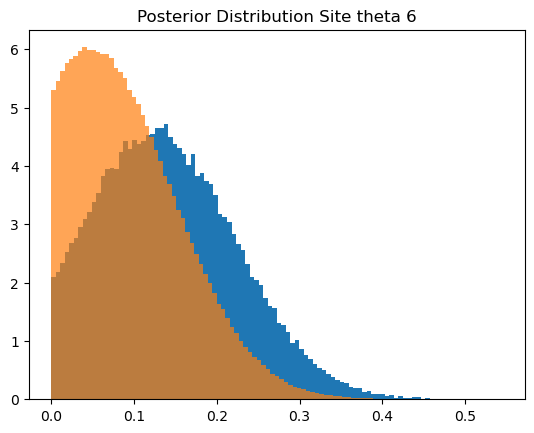

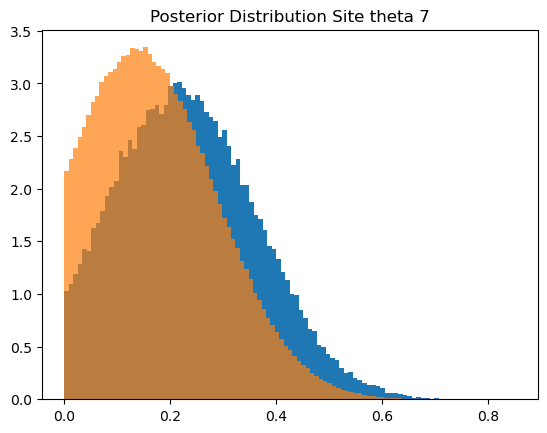

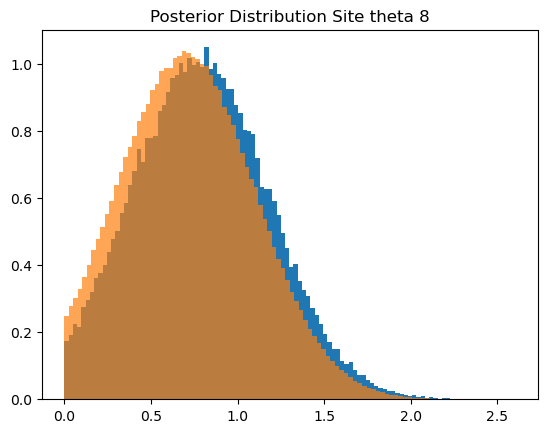

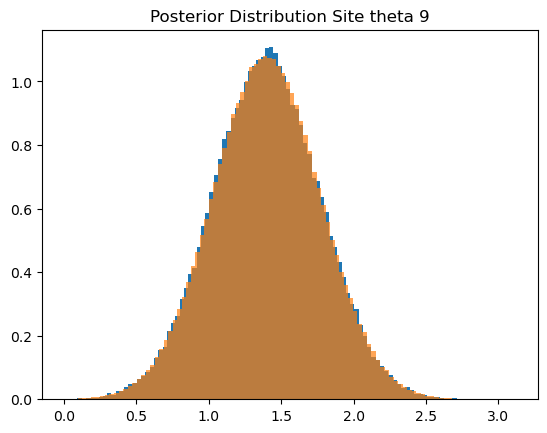

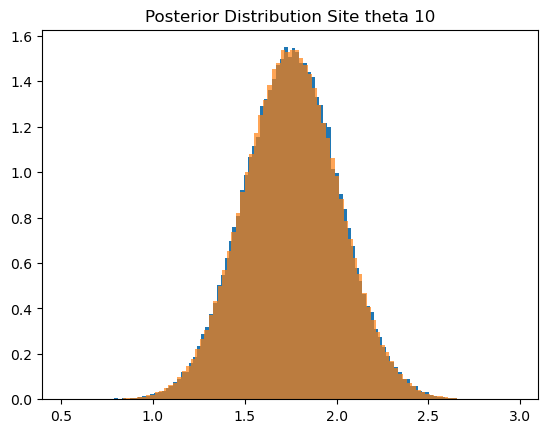

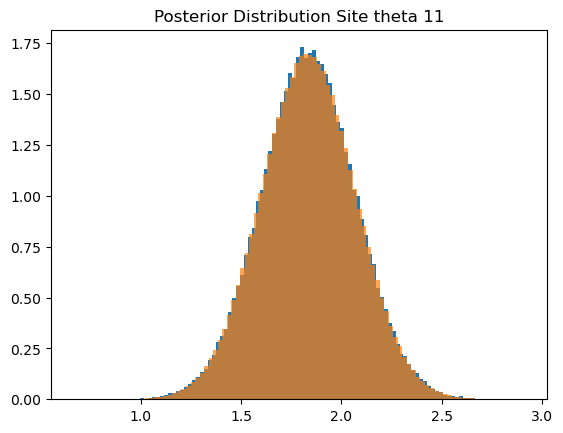

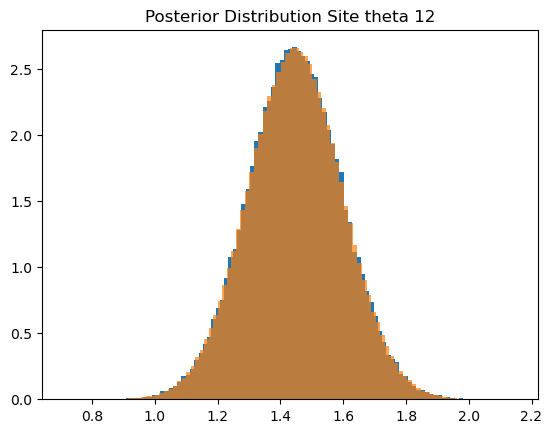

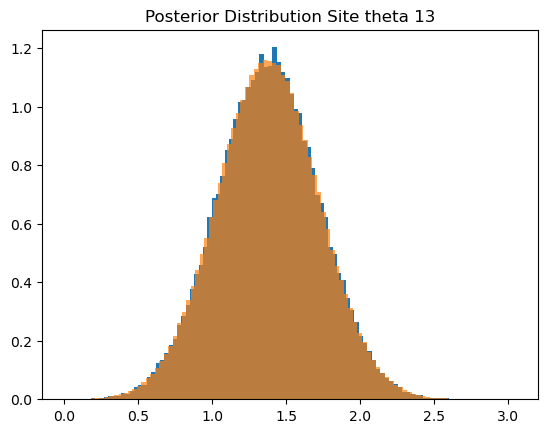

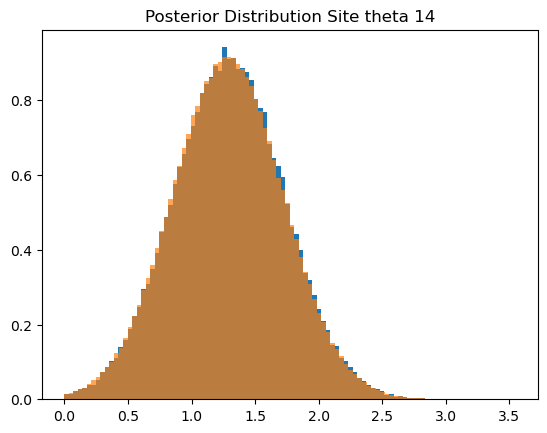

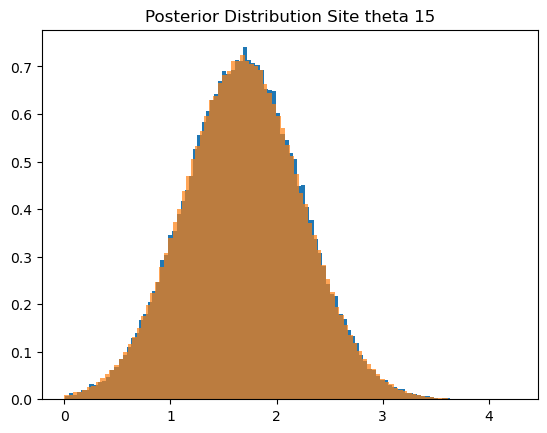

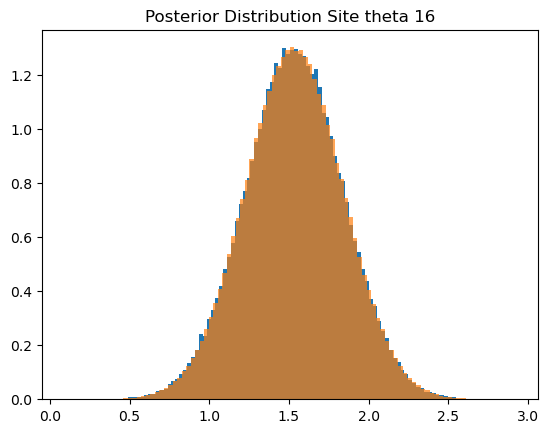

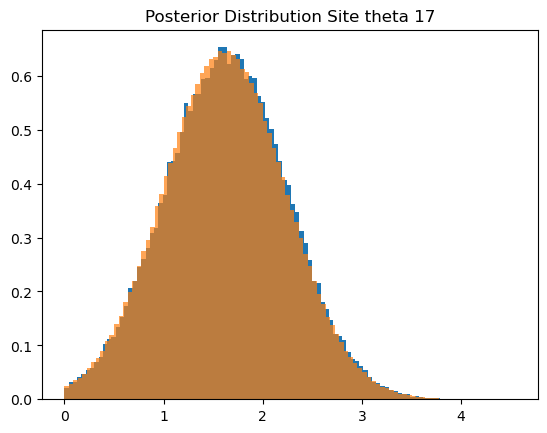

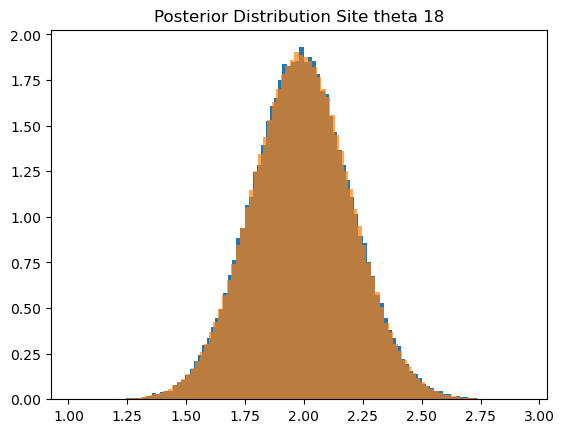

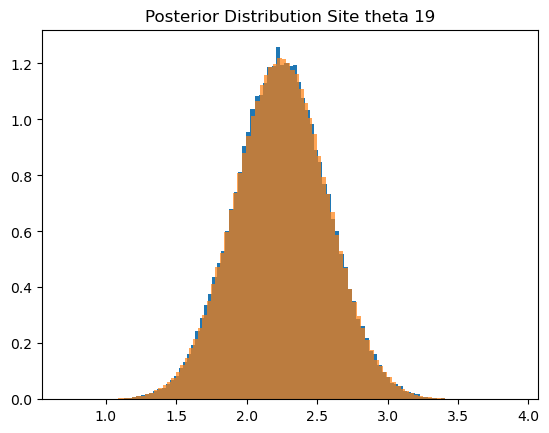

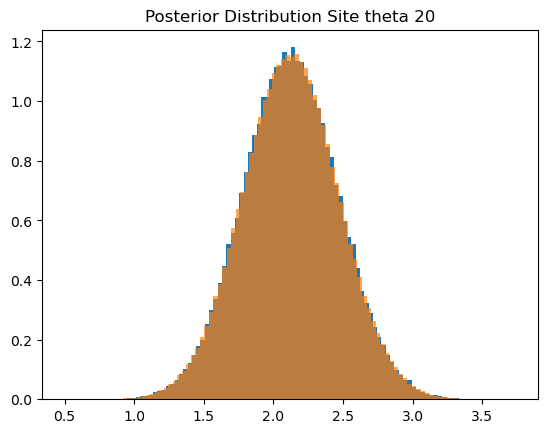

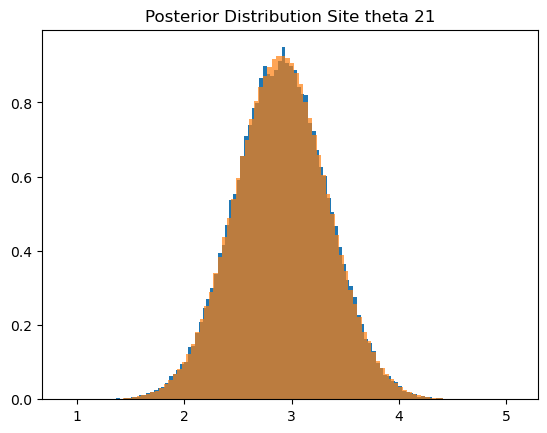

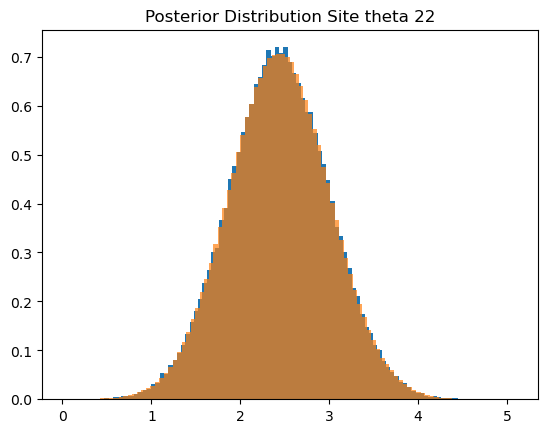

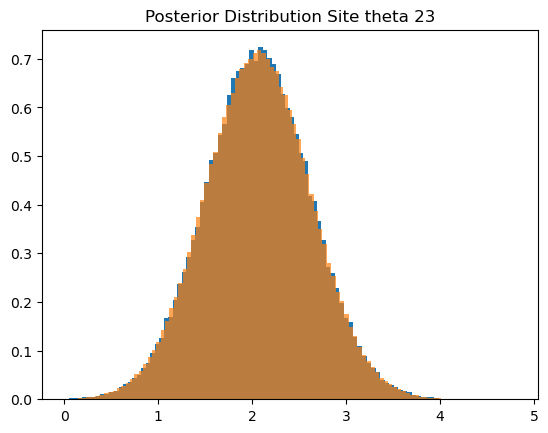

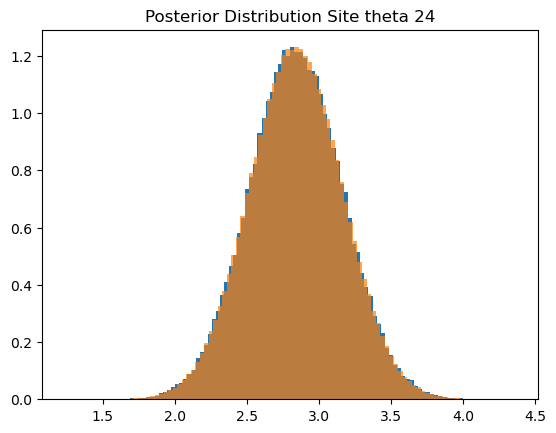

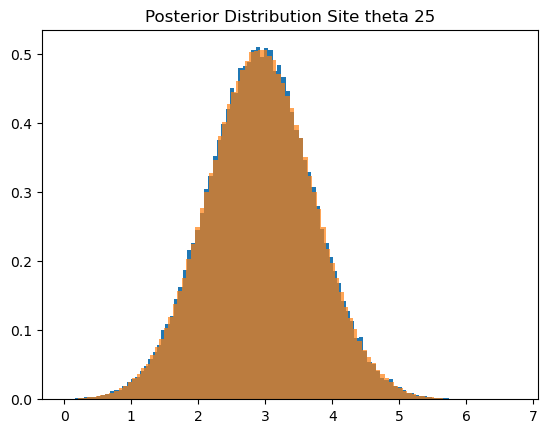

In [ ]:
for i in range(n):
    plt.hist(Posterior[:,i], bins = 100, density=True)
    plt.hist(list_mc[:,i], bins = 100, alpha=0.7, density=True)
    plt.legend(['post', 'prior'])

    plt.title(f'Posterior Distribution Site gamma {i+1}')
    plt.show()
for i in range(n):
    plt.hist(Posterior[:,i+n], bins = 100, density=True)
    plt.hist(list_mc[:,i+n], bins = 100, alpha=0.7, density=True)
    plt.legend(['post', 'prior'])
    plt.title(f'Posterior Distribution Site theta {i+1}')
    plt.show()

In [22]:
np.mean(np.load('pe_20.76_xi_10_25sites.npy'),axis=0)[0:n]

array([527.98463153, 464.47078675, 526.53954022, 624.39105653,
       695.38166111, 629.64484806, 505.10373762, 504.09518168,
       576.73137471, 519.83052765, 349.40083023, 245.92570894,
       897.72238187, 638.90635523, 534.28452672, 644.28456552,
       398.11181448, 334.5368145 , 847.76691689, 554.23786853,
       494.23225948, 353.8871185 , 381.45012617, 335.34233175,
       277.42332872])

In [23]:
np.mean(np.load('pe_20.76_xi_10_25sites.npy'),axis=0)[n:]

array([0.12989313, 0.16848182, 0.44782733, 1.13767822, 1.72960849,
       0.14763087, 0.22179752, 0.82148626, 1.25406137, 1.76982429,
       1.77622964, 1.40128859, 1.46828954, 1.31649519, 1.62287647,
       1.51144155, 1.6109034 , 1.94439364, 2.14770204, 2.17717749,
       2.9201727 , 2.40419028, 2.04193967, 2.8172804 , 2.65842921])